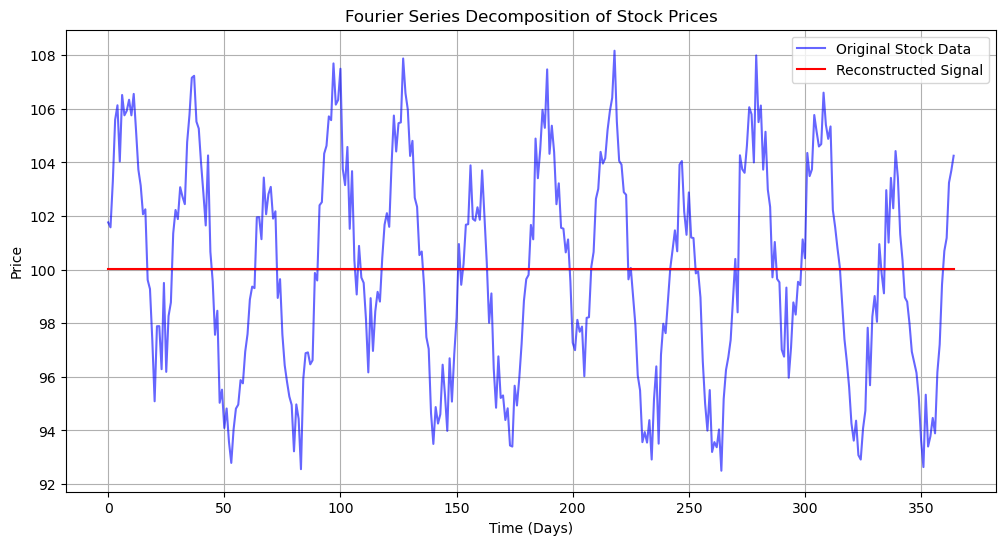

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, ifft

# Step 1: Create Synthetic Stock Data
np.random.seed(0)
days = 365  # Number of days (e.g., 1 year of daily data)
time = np.arange(0, days)

# Simulated price data with cyclical patterns
price_data = 100 + 5 * np.sin(2 * np.pi * time / 30)  # Monthly cycle (30 days)
price_data += 2 * np.sin(2 * np.pi * time / 90)  # Quarterly cycle (90 days)
price_data += np.random.normal(0, 1, days)  # Add some random noise

# Step 2: Apply Fourier Transform
price_fft = fft(price_data)  # Fourier Transform
frequencies = fftfreq(days)  # Frequency components

# Step 3: Filter significant frequencies (frequency components with high amplitude)
amplitude = np.abs(price_fft)
threshold = amplitude.max() * 0.3  # Filter threshold (30% of max amplitude)
significant_freqs = frequencies[amplitude > threshold]
significant_amplitudes = price_fft[amplitude > threshold]

# Step 4: Inverse Fourier Transform to reconstruct signal from significant frequencies
filtered_fft = np.where(amplitude > threshold, price_fft, 0)  # Retain significant frequencies only
reconstructed_signal = ifft(filtered_fft).real

# Plot the Original vs. Reconstructed Data
plt.figure(figsize=(12, 6))
plt.plot(time, price_data, label='Original Stock Data', color='blue', alpha=0.6)
plt.plot(time, reconstructed_signal, label='Reconstructed Signal', color='red', linewidth=1.5)
plt.title("Fourier Series Decomposition of Stock Prices")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

Expected Return (Mean): 0.08
Variance: 0.04000000000000001
Probability of experiencing returns below -10.0%: 0.18406012534675953


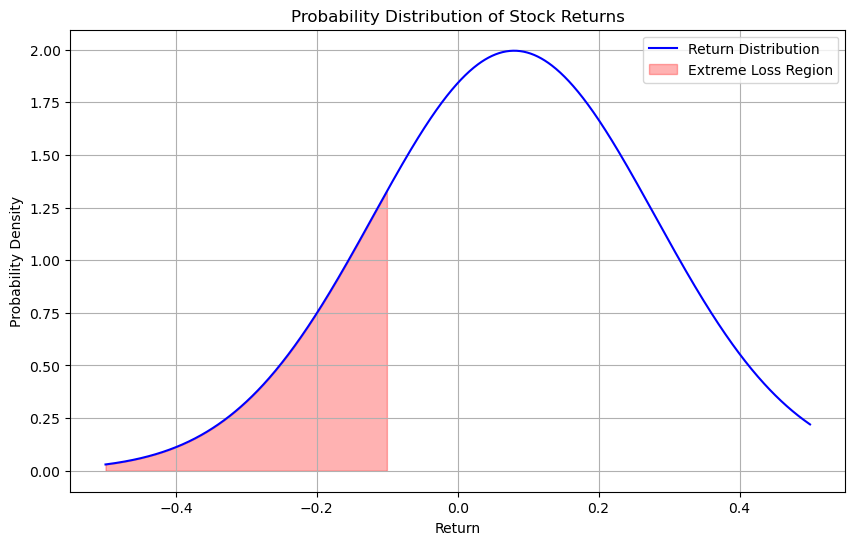

In [6]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Step 1: Define parameters for a stock's return distribution
mu = 0.08  # Expected annual return (8%)
sigma = 0.2  # Annual volatility (20%)

# Step 2: Define the Moment Generating Function (MGF) for a normal distribution
def mgf_normal(t, mu, sigma):
    return np.exp(mu * t + 0.5 * sigma**2 * t**2)

# Step 3: Calculate the first moment (Mean) and second moment (Variance)
# Mean = derivative of MGF at t=0
mean = mu

# Variance = second derivative of MGF at t=0 - (first derivative)^2
variance = sigma**2

print("Expected Return (Mean):", mean)
print("Variance:", variance)

# Step 4: Use the MGF to analyze probabilities of extreme events
# Calculate the probability of returns falling below a certain threshold (e.g., -0.1 or -10%)
threshold_return = -0.1
z_score = (threshold_return - mean) / sigma
prob_extreme_loss = norm.cdf(z_score)

print(f"Probability of experiencing returns below {threshold_return*100}%:", prob_extreme_loss)

# Step 5: Visualize the probability distribution and highlight the extreme loss area
returns = np.linspace(-0.5, 0.5, 1000)  # Range of returns from -50% to 50%
pdf = norm.pdf(returns, mean, sigma)  # Probability density function

plt.figure(figsize=(10, 6))
plt.plot(returns, pdf, label="Return Distribution", color="blue")
plt.fill_between(returns, pdf, where=(returns <= threshold_return), color="red", alpha=0.3, label="Extreme Loss Region")
plt.title("Probability Distribution of Stock Returns")
plt.xlabel("Return")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

# Fix threading issues by limiting threads
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Step 1: Fetch stock data
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2024-01-01')['Adj Close']

# Step 2: Preprocess the data
# Calculate daily returns
returns = data.pct_change().dropna()

# Reshape the returns to a 2D array for HMM
returns_scaled = returns.values.reshape(-1, 1)

# Standardize the returns for model stability
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_scaled)

# Step 3: Fit an HMM to the data
n_states = 3  # Number of hidden states
hmm_model = GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=1000, random_state=42)

try:
    # Fit the model
    hmm_model.fit(returns_scaled)

    # Step 4: Predict hidden states
    hidden_states = hmm_model.predict(returns_scaled)

    # Step 5: Analyze the results
    # Add hidden states to the data
    returns_df = pd.DataFrame({'Date': returns.index, 'Returns': returns.values, 'State': hidden_states}).set_index('Date')

    # Plot the states
    plt.figure(figsize=(12, 6))
    for state in range(n_states):
        state_data = returns_df[returns_df['State'] == state]
        plt.scatter(state_data.index, state_data['Returns'], label=f'State {state}', alpha=0.5)
    plt.title(f'Hidden Markov Model: Hidden States for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Daily Returns')
    plt.legend()
    plt.show()

    # Step 6: Transition probabilities and means
    print("\nTransition Probabilities:")
    print(hmm_model.transmat_)

    print("\nState Means (Scaled):")
    print(hmm_model.means_)

    # Inverse transform the means to original scale
    state_means = scaler.inverse_transform(hmm_model.means_)
    print("\nState Means (Original Scale):")
    print(state_means)

except Exception as e:
    print(f"An error occurred: {e}")

[*********************100%%**********************]  1 of 1 completed

An error occurred: 'NoneType' object has no attribute 'split'


[*********************100%%**********************]  1 of 1 completed


Mean Squared Error: 0.38
R-squared: 1.00


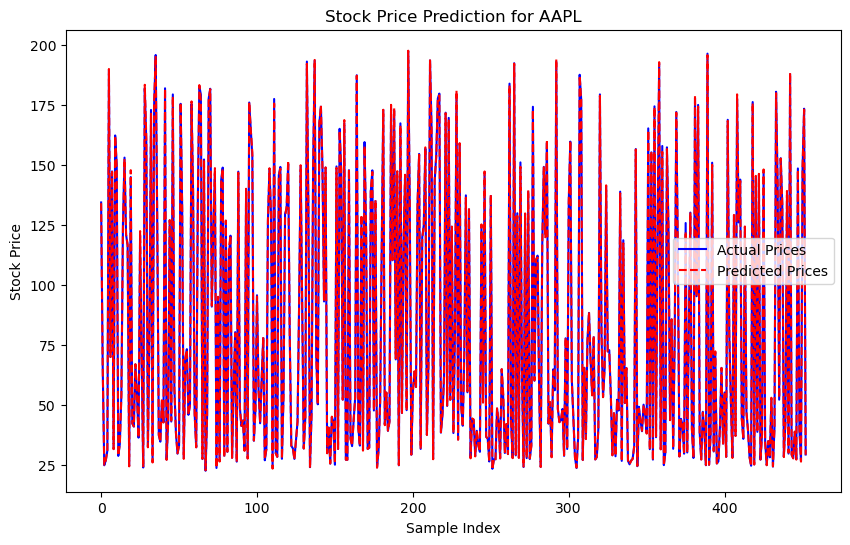

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf

# Step 1: Fetch historical stock data
stock_ticker = "AAPL"  # Replace with your desired stock ticker
data = yf.download(stock_ticker, start="2015-01-01", end="2023-12-31")

# Step 2: Preprocess the data
data['Daily Return'] = data['Close'].pct_change()  # Add daily returns as a feature
data.dropna(inplace=True)  # Remove NaN rows

# Features (X) and Target (y)
X = data[['Open', 'High', 'Low', 'Volume', 'Daily Return']]
y = data['Close']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Step 7: Visualize the predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction for {stock_ticker}")
plt.xlabel("Sample Index")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed

Mean Squared Error: 3.80
R-squared: 1.00
Predicted Next Day's Closing Price: $194.20



C:\Users\sudhi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


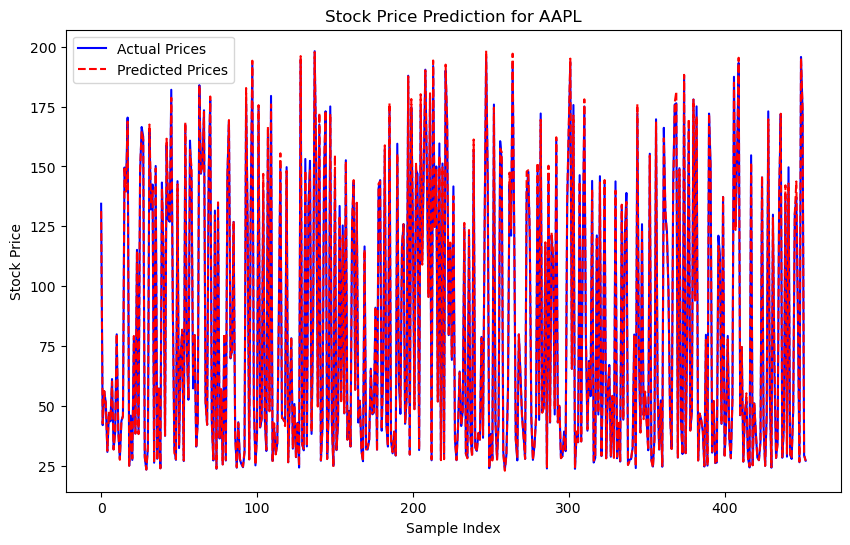

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf

# Step 1: Fetch historical stock data
stock_ticker = "AAPL"  # Replace with your desired stock ticker
data = yf.download(stock_ticker, start="2015-01-01", end="2023-12-31")

# Step 2: Preprocess the data
data['Daily Return'] = data['Close'].pct_change()  # Add daily returns as a feature
data['Next Close'] = data['Close'].shift(-1)  # Target: Next day's closing price
data.dropna(inplace=True)  # Remove NaN rows

# Features (X) and Target (y)
X = data[['Open', 'High', 'Low', 'Volume', 'Daily Return']]
y = data['Next Close']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Step 7: Predict the next day's closing price
last_row = X.iloc[-1, :].values.reshape(1, -1)  # Get the last available feature row
next_day_price = model.predict(last_row)[0]
print(f"Predicted Next Day's Closing Price: ${next_day_price:.2f}")

# Step 8: Visualize the predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", color="red", linestyle="dashed")
plt.title(f"Stock Price Prediction for {stock_ticker}")
plt.xlabel("Sample Index")
plt.ylabel("Stock Price")
plt.legend()
plt.show()